# Le Programme Cell Chain Article version Septembre 2014

## Les imports

In [188]:
import numpy as np
from sys import stdout
from itertools import chain
%matplotlib inline
import matplotlib.pyplot as plt
from warnings import catch_warnings, filterwarnings
import pylab
from scipy import fftpack

## La classe cell

In [321]:

### il faut mettre une majuscule aux noms de classe (Cell)
class cell() :
    """Handles all things physical!"""

    def __init__(self, dt, freq, L_x_0, L_x_dot_0, v_adh_0, F_adh0,
                 m_cc=0.1, eta_cc=0.5, G_cc_dot=0., 
                 m_cm=0.1, eta_cm=0.5, G_cm_dot=0.,
                 V_dot=0.) :
        
        self.steps_elapsed = 0
    
        # Global variables string list
        self.vars = [['dt', 'freq',\
                      'm_cc','eta_cc','G_cc_dot', \
                      'm_cm','eta_cm','G_cm_dot', 'F_adh0',\
                      'v_adh_0', 'L_x_dot_0','L_x_0','V_dot'], \
                     ['sigma_cc','sigma_cm','v_sqz','L_buck', \
                      'L_cc','L_cm','theta','L_x', 'G_cc','G_cm','s','thetime','v_adh','L_x_dot','force','Volume']]
            
        
        self.list = list(chain.from_iterable(self.vars))
        
        sigma_cc = 0.0378112500962
        sigma_cm = 0.0557574320458
        v_sqz = 0.
        L_buck = 0.
        L_cc = 0.51832867931
        L_cm = 1.09732599832
        theta = 1.48682076362
        L_x = L_x_0
        G_cc = 1.
        G_cm = 1.
        s = 0
        thetime = 0.
        v_adh=0.00631778245004
        L_x_dot = L_x_dot_0
        force = 0.0429343631124
        Volume = (L_cc-L_buck)*L_x+L_cm**2*(theta-np.sin(theta))/theta**2
        
        
        # Parameters initialisation ## Ici il vaut mieux utiliser `setattr`
        for var in self.vars[0] : 
            ### On mélange le `var` la chaîne de caractère et var
            ### passé en argument. Je suis surpris que ça marche en python 2
            ### ça plante en python3
            exec 'self.'+var+' = np.float64('+var+') * np.ones(1)'
            
            ### D'autre part, ça n'est pas la peine de convertir les variables en
            ### array de longueur 1, si besoin, python fera la conversion
            ### toutes les opérations de numpy peuvent prendre un `float` en argument
                                
        # Variables initialization
        for var in self.vars[1] : 
            exec 'self.'+var+' = np.float64('+var+') * np.ones(2)'
            
        self.update_diff()
        
        
    def update_diff(self) :
        """Computes differentials through linear inversion"""

        safety = 1e100
        
        ### ici, on pourrait simplement utiliser v_adh, sans indissage
        self.v_adh[0] = self.v_adh_0 * (1-self.sigma_cm[0] * np.sin((np.pi-self.theta[0])/2.0)/self.F_adh0)
        #self.v_adh[0] += self.dt * (self.v_adh_0 * (1-self.sigma_cm[0] * np.sin((np.pi-self.theta[0])/2.0)/self.F_adh0) - self.v_adh[0]) / (50*self.dt)
        #self.v_adh[0] = self.v_adh_0
        
        self.force[0] = self.sigma_cm[0] * (2.0 * np.cos(self.theta[0]/2.0) - self.theta[0] * self.L_cc[0]/self.L_cm[0])
        
        if self.theta[0]**2./safety == 0. :
            ### Cette condition est casse gueule, on compare un float à 0. pourquoi pas
            ### mettre un cutoff sur theta (p.ex. 1e-8) et vérifier 
            ### self.theta < cutoff 
            ### ce n'est jamais une très bonne idée de comparer l'égalité stricte de 
            ### deux flottants (à cause des erreurs d'arrondi)
            
            self.Volume[0] = (self.L_cc[0]-self.L_buck[0]) * self.L_x[0]
        else :
            self.Volume[0] = (self.L_cc[0]-self.L_buck[0]) * self.L_x[0] + self.L_cm[0]**2*(self.theta[0]-np.sin(self.theta[0]))/self.theta[0]**2
            
            
        for var in self.list : 
            exec var+' = self.'+var+'.copy()[0]'
        
        M = np.zeros([7, 7])
        Vec = np.zeros(7)
 
        M[0,0] = 1.
        M[0,1] = -np.sin(theta/2.)
        M[0,2] = 0.
        M[0,3] = 0.
        M[0,4] = 0.
        M[0,5] = 0.
        M[0,6] = -sigma_cm/2.*np.cos(theta/2.)
        Vec[0] = 0.
             
        M[1,0] = 0.
        M[1,1] = 0.
        M[1,2] = 0.
        M[1,3] = 0.
        if theta/2./safety == 0. : # même remarque que ci-dessus
            M[1,4] = 1.
        else :
            M[1,4] = np.sin(theta/2.)/(theta/2.)
        M[1,5] = 0.
        if theta**2./4./safety == 0. :
            M[1,6] = L_cm/2. * (-theta/6.)
        else :
            M[1,6] = L_cm/2. * (np.cos(theta/2.)*theta/2.-np.sin(theta/2.))/(theta**2./4.)
        #M[1,6] = L_cm/2. * (np.cos(theta/2.)*theta/2.-np.sin(theta/2.))/(theta**2./4.)
            
        Vec[1] = L_x_dot
                               
        M[2,0] = 0.
        M[2,1] = 0.
        M[2,2] = 0.
        M[2,3] = -L_x
        if theta**2./safety ==  0. :
            M[2,4] = 2. * L_cm * theta/6.
        else :
            M[2,4] = 2. * L_cm * (theta-np.sin(theta)) / theta**2.    
        #M[2,4] = 2. * L_cm * (theta-np.sin(theta)) / theta**2.    
        M[2,5] = L_x
        if theta**3./safety == 0. :
            M[2,6] = L_cm**2. * 1./6.
        else :
            M[2,6] = L_cm**2. * (2.*np.sin(theta) -np.cos(theta)*theta -theta) / theta**3.
        #M[2,6] = L_cm**2. * (2.*np.sin(theta) -np.cos(theta)*theta -theta) / theta**3.
            
        Vec[2] = V_dot -(L_cc-L_buck)*L_x_dot

        M[3,0] = -L_cc/G_cc
        M[3,1] = 0.
        M[3,2] = -2.
        M[3,3] = 0.
        M[3,4] = 0.
        M[3,5] = 1.
        M[3,6] = 0.
        Vec[3] = L_cc*((1./eta_cc-G_cc_dot/G_cc**2.)*sigma_cc-m_cc) +2.*v_adh

        M[4,0] = 0.
        M[4,1] = -L_cm/G_cm
        M[4,2] = 2
        M[4,3] = 0.
        M[4,4] = 1.
        M[4,5] = 0.
        M[4,6] = 0.
        Vec[4] = L_cm*((1./eta_cm-G_cm_dot/G_cm**2.)*sigma_cm-m_cm)-2.*v_adh
        
        M[5,0] = 0.
        M[5,1] = 0.
        M[5,2] = (1.+s)*(2.-s)/2.
        M[5,3] = 0.
        M[5,4] = 0.
        M[5,5] = 0.
        M[5,6] = (s-1.)*s/2.
        Vec[5] = 0. 
        
        M[6,0] = 0.
        M[6,1] = 0.
        M[6,2] = 0.
        M[6,3] = (2.+s)*(1.-s)/2.
        M[6,4] = 0.
        M[6,5] = 0.
        M[6,6] = (s+1.)*s/2.
        Vec[6] = 0. 


        self.determ = np.linalg.det(M) * np.ones(1)
        #print self.determ
        self.v_sqz[0] = self.v_sqz[1] # keep track of previous v_sqz

        # find variable derivatives
        ### je trouve un peu bizarre de stocker les vitesses et les positions 
        ### dans un vecteur à 2 éléments, mais bon pourquoi pas
        ### le traitement de v_sqz est différent, c'est un peu chelou
        self.sigma_cc[1], self.sigma_cm[1], self.v_sqz[1], \
             self.L_buck[1], self.L_cm[1], self.L_cc[1],\
             self.theta[1] \
                = np.linalg.solve(M, Vec)



    def increment(self,deltat) :
        self.thetime += deltat
        self.sigma_cc[0] += self.sigma_cc[1] * deltat
        self.sigma_cm[0] += self.sigma_cm[1] * deltat
        self.L_buck[0] += self.L_buck[1] * deltat
        self.L_cm[0] += self.L_cm[1] * deltat
        self.L_cc[0] += self.L_cc[1] * deltat
        self.theta[0] += self.theta[1] * deltat
        self.L_x[0] += self.L_x_dot[0] * deltat
        self.G_cc[0] += self.G_cc_dot * deltat
        self.G_cm[0] += self.G_cm_dot * deltat
                     
    def step(self,dt) :
        """Main iteration function"""

        self.steps_elapsed += 1
        self.time = self.steps_elapsed * dt

        self.increment(dt)
        
        test = 0
        if (self.s[0] == 0) & (test == 0) :
            self.L_buck[0] = 0.0
            
            if (self.theta[0] >= np.pi) & (self.theta[1] > 0.0) :
                self.s[0] = -1
                # backtime is supposed to be positive
                backtime = (self.theta[0] - np.pi) / self.theta[1]
                self.increment(-backtime)
                self.theta[0] = np.pi
                test = 1

            if (self.theta[0] <= 0.0) & (self.theta[1] < 0.0) :
                self.s[0] = 1
                # backtime is supposed to be positive
                backtime = - (0.0 - self.theta[0]) / self.theta[1]
                self.increment(-backtime)
                self.theta[0] = 0.0
                test = 1
                
        if (self.s[0] == 1) & (test == 0) :
            self.theta[0] = 0.0
            
            if (self.L_buck[0] <= 0.0) & (self.L_buck[1] < 0.0) :
                self.s[0] = 0
                # backtime is supposed to be positive
                backtime = -(0.0 - self.L_buck[0]) / self.L_buck[1]
                self.increment(-backtime)
                test = 1
        
        if (self.s[0] == -1) & (test == 0) :
            self.L_buck[0] = 0.0
            self.theta[0] = np.pi
            
            if (self.v_sqz[1] < 0.0) :
                self.s[0] = 0
                # backtime is supposed to be positive
                backtime = self.v_sqz[1] / (self.v_sqz[1] - self.v_sqz[0]) * self.dt
                self.increment(-backtime)
                test = 1
            
        
        self.update_diff()
        
    def L_x_dot_function(self,t,Nstep) :
        
        for var in self.list : 
            exec var+' = self.'+var+'.copy()[0]'
        
        L_x_dot = L_x_dot_0
        #if t >= Nstep/4. :
        #    L_x_dot = self.L_x_dot_0 * (1. - 1./(1.+((t-Nstep/4.)/(Nstep/7.))**6.))
            
        #if t >= 3.0*Nstep/4.0 :
        #    L_x_dot = 0.0
        if (self.freq != 0) :
            L_x_dot = - min(1./10. * min(G_cc/eta_cc,min(m_cc,v_adh_0/L_x_0)) /freq, L_x_0/5) * 2. * np.pi * freq * np.sin(2*np.pi*freq*t*dt)
        return L_x_dot

        

## L'itération

In [322]:
dt=1e-1
time_sim=50
freq=1.e1
freq=0
if freq !=0 : 
        dt = min(1. / (500 * freq), 9e-1)
        time_sim=50 + 5./freq
        print dt
tol=1e-2
plot=True
Nstep = int(round(time_sim / dt))

CSI   = "\x1B["
reset = CSI+"m"  

color_str = lambda X: CSI+"34;49m"+str(X)+reset
info_str = map(color_str, (Nstep, round(time_sim, 2)))

print 'Max. number of steps : %s (sim. time : %ss)' % tuple(info_str)
    
# Exit mode - 0=normal, 1=problem with Lenghts, 2=problem with determinant
ex = 0
          
# Function class instance - cell.py
syst = cell(dt=dt,freq=freq,L_x_0=1.,L_x_dot_0=0.,v_adh_0=0.02,F_adh0=0.06)

# Variables to be displayed
Vars = chain.from_iterable(syst.vars[1:])
Vars = list(Vars)
print Vars
    
for var in Vars: exec var+' = np.zeros(Nstep)' in globals(), locals()

# Vectorial storage
for t in range(Nstep) :
    #print t
    for var in Vars: exec var+'[t] = syst.'+var+'[0]' in globals(), locals()
    
    syst.L_x_dot[0] = syst.L_x_dot_function(t,Nstep)

     # Iteration
    syst.step(dt)

    if (syst.L_cc[0] < 0.) | (syst.L_cm[0] <= 0.) :
            Nstep = syst.steps_elapsed
            ex = 1
            break          
    elif abs(syst.determ[0]) < tol :
            Nstep = syst.steps_elapsed
            ex = 2
            break
            
print 'Simulation ended after %s steps.\t(Exit mode %i)' \
    % (color_str(Nstep), ex)
        
    
        
for var in Vars : 
    exec var+' = '+var+'[:Nstep]' in globals(), locals()


Tmax=Nstep


Max. number of steps : 500 (sim. time : 50.0s)
['sigma_cc', 'sigma_cm', 'v_sqz', 'L_buck', 'L_cc', 'L_cm', 'theta', 'L_x', 'G_cc', 'G_cm', 's', 'thetime', 'v_adh', 'L_x_dot', 'force', 'Volume']
Simulation ended after 500 steps.	(Exit mode 0)


## Sauvegarde résultats texte

In [ ]:
S = np.column_stack((thetime,sigma_cc,sigma_cm,v_sqz,L_buck,L_cc,L_cm,theta,L_x,G_cc,G_cm,s))
np.savetxt('Results.txt', S)

## Les graphes

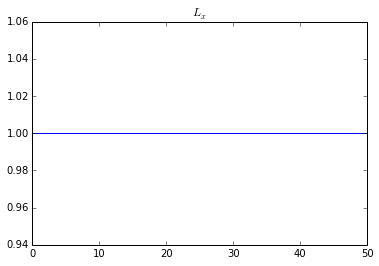

In [283]:
plt.plot(thetime[:Tmax], L_x[:Tmax])
plt.xlim([0, Nstep*dt])
plt.title(r'$L_x$') 

In [ ]:
plt.plot(thetime[1:Tmax], L_x_dot[1:Tmax])
plt.xlim([0, Nstep*dt])
plt.title(r'$\dot{L_x}$') 

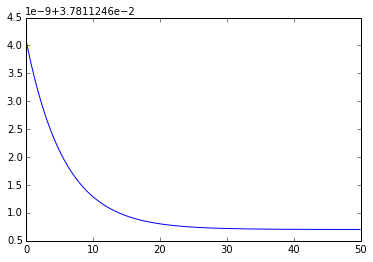

In [311]:
plt.plot(thetime[:Tmax], sigma_cc[:Tmax])
#plt.xlim([0, Nstep*dt])

In [ ]:
plt.plot(thetime[:Tmax], sigma_cm[:Tmax])
#plt.xlim([0, Nstep*dt])
plt.title(r'$\sigma_{cm}$') 

In [ ]:
plt.plot(thetime[:Tmax], L_buck[:Tmax])
#plt.xlim([0, Nstep*dt])
plt.title(r'$L_{buck}$')

In [ ]:
plt.plot(thetime[:5000], L_cc[:5000]-L_buck[:5000])
#plt.xlim([0, Nstep*dt])
plt.title(r'$L_{cceff}$')   

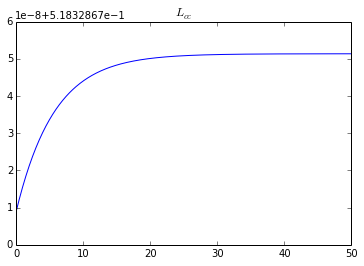

In [312]:
plt.plot(thetime[:Tmax], L_cc[:Tmax])
#plt.xlim([0, Nstep*dt])
plt.title(r'$L_{cc}$')   

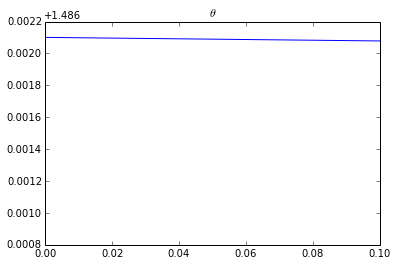

In [293]:
plt.plot(thetime[:Tmax], theta[:Tmax])
plt.xlim([0, Nstep*dt])
plt.title(r'$\theta$')   

In [ ]:
#plt.plot(thetime, G_cc)
#plt.xlim([0, Nstep*dt])
#plt.title(r'$G_{cc}$')   

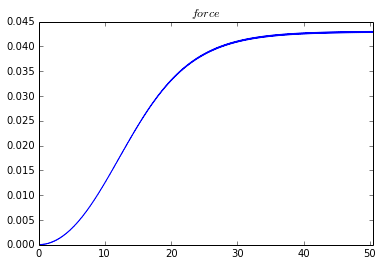

In [198]:
plt.plot(thetime[:Tmax], force[:Tmax])
plt.xlim([0, Nstep*dt])
plt.title(r'$force$')

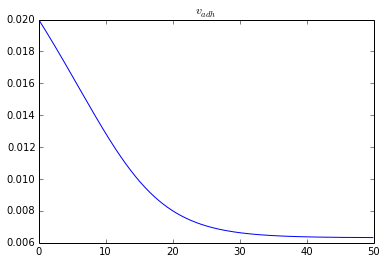

In [274]:
plt.plot(thetime[:Tmax], v_adh[:Tmax])
plt.xlim([0, Nstep*dt])
plt.title(r'$v_{adh}$')

In [ ]:
plt.plot(thetime[:Tmax], s[:Tmax])
#plt.xlim([0, Nstep*dt])
plt.title(r'$s$')

In [ ]:
plt.plot(T, thetime)
plt.xlim([0, Nstep*dt])
plt.title(r'$thetime$')

In [ ]:
plt.plot(thetime[:Tmax], Volume[:Tmax])
plt.xlim([0, Nstep*dt])
plt.title(r'$Volume$')

In [ ]:
plt.plot(thetime[:Tmax], L_cc[:Tmax] * L_x[:Tmax])
plt.xlim([0, Nstep*dt])

In [ ]:
plt.plot(thetime[:Tmax], L_cm[:Tmax]**2 * (theta[:Tmax]-np.sin(theta[:Tmax]))/theta[:Tmax]**2)
plt.xlim([0, Nstep*dt])

In [ ]:
# Geometric variables
res = 500
Nadj = 1


im_numb=Nstep-1

alpha=(np.pi-theta[im_numb-1])/2.
R=L_x[im_numb-1]/np.cos(alpha)/2.

print alpha
print L_x[im_numb-1]


l = 2 * R * np.cos(alpha)
l_cc=L_cc[im_numb-1]



tmpX = -l / 2 * np.ones(res)
tmpY = R * np.sin(alpha)

thetap = np.linspace(alpha, np.pi - alpha, num=res)
y = np.linspace(l_cc/2, -l_cc/2, num=res)

# Draw round sides
round1 = (R * np.cos(thetap), R * np.sin(thetap) - tmpY +l_cc/2)
round2 = (-round1[0], -round1[1])

# Draw flat sides
flat1 = (tmpX, y)
flat2 = (-flat1[0], -flat1[1])
    
# Add adjacent cells
size = int((Nadj - 1) / 2) 
xc = l * np.linspace(-size, size, num=Nadj)

sep = np.empty([2,1])
sep.fill(np.nan)

for cell in range(Nadj) :
    round1 = np.hstack((round1, sep, (round1[0]+xc[cell], round1[1])))
    round2 = np.hstack((round2, sep, (round2[0]+xc[cell], round2[1])))
    flat1 = np.hstack((flat1, sep, (flat1[0]+xc[cell], flat1[1])))
    flat2 = np.hstack((flat2, sep, (flat2[0]+xc[cell], flat2[1])))
    
tr = 5.0
plt.axes(aspect='equal')
plt.plot(round1[0] ,round1[1], lw=tr,color='b')
plt.plot(round2[0] ,round2[1], lw=tr,color='b')
plt.plot(flat1[0] ,flat1[1], lw=tr,color='b')
plt.plot(flat2[0] ,flat2[1], lw=tr,color='b')

pylab.savefig('Figure.png',dpi=300)

In [308]:
print sigma_cc[Tmax-1]
print sigma_cm[Tmax-1]
print L_cc[Tmax-1]
print L_cm[Tmax-1]
print theta[Tmax-1]
print L_x[Tmax-1]
print L_x_dot[Tmax-1]
print v_adh[Tmax-1]
print force[Tmax-1]

0.0378112500962
0.0557574320458
0.51832867931
1.09732599832
1.48682076362
1.0
0.0
0.00631778245004
0.0429343631124


## Mode oscillant

In [296]:
def run(dt, time_sim, time_trans, freq, plot) :
    """Omitted variables will default to the values in __init__"""
 
    dt_i = dt
    dt_f = dt
    Nstep = int(round(time_trans / dt_i + (time_sim - time_trans) / dt_f))
    
    color_str = lambda X: CSI+"34;49m"+str(X)+reset
    info_str = map(color_str, (Nstep, freq, round(time_sim, 2)))

    print 'Max. number of steps : %s (freq. : %sHz, sim. time : %ss)' \
        % tuple(info_str)
    
    # Exit mode - 0=normal, 1=L, 2=det
    ex = 0 
    
    # Function class instance - cell.py
    syst = cell(dt=dt,freq=freq,L_x_0=1.,L_x_dot_0=0.,v_adh_0=0.02,F_adh0=0.06)

    # Variables to be displayed
    Vars = chain.from_iterable(syst.vars[1:])
    Vars = list(Vars)
    
    for var in Vars: exec var+' = np.zeros(Nstep)' in globals(), locals()

    # Vectorial storage
    for t in range(Nstep) :
        #print t
        if syst.thetime[0]<= time_trans: dt = dt_i
        else: dt = dt_f
        
        for var in Vars: exec var+'[t] = syst.'+var+'[0]' in globals(), locals()

        syst.L_x_dot[0] = syst.L_x_dot_function(t,Nstep)
        
        # Iteration
        syst.step(dt)


        if (syst.L_cc[0] < 0.) | (syst.L_cm[0] <= 0.) :
            Nstep = syst.steps_elapsed
            ex = 1
            break          
        elif abs(syst.determ[0]) < tol :
            Nstep = syst.steps_elapsed
            ex = 2
            break

    print 'Simulation ended after %s steps.\t(Exit mode %i)' \
        % (color_str(Nstep), ex)
    
    res = []
        
    for var in Vars : 
        exec var+' = '+var+'[:Nstep]' in globals(), locals()
        exec 'res.append('+var+')' in globals(), locals()
    return Vars, res

In [314]:
def response(dt, time_sim, time_trans, freq) :
    """Computes responses to a given mode through Fourier analysis"""
 
    Ntrans = int(round(time_trans / dt))
    pulse = 2*np.pi * freq * dt

    # Call run function - run.py
    lst, res= run(dt=dt, time_sim=time_sim, time_trans=time_trans,
                   plot=False, freq=freq)
    
    lst = np.asarray(lst)
    res = np.asarray(res)
    
    
    # Variables to be computed
    Vars = ['L_x','L_x_dot','force','thetime','sigma_cc','sigma_cm','v_sqz','L_buck','L_cc','L_cm','theta','s']
    
    # Unpack variables  
    for var in Vars: 
        exec var+' = res[lst=="'+var+'"][0]'
    
    
    
    for var in Vars :
        exec var+' = '+var+'[Ntrans:]'
        
    ampl=(max(L_x) - min(L_x))/2.
    
    
    
    ##########

    # Fourier transforms
    for var in Vars :
        exec 'f'+var+' = fftpack.fft('+var+')'
    
    fL_xr = fL_x.conjugate()
    for var in Vars[1:] :
        # Phase-shifts from cross-correlation functions
        exec 'shift'+var+' = np.argmax(np.abs(fftpack.ifft(fL_xr * f'+var+'))) * pulse'

        exec 'shift'+var+' = shift'+var+' % (2*np.pi)'
        
        # Transfer function modulii
        exec 'ratio'+var+' = np.max(np.abs(f'+var+'[1:])) / np.max(np.abs(fL_x[1:]))'

    
    phase = [shiftforce]
    modul = [ratioforce]
    
    phase = np.asarray(phase)
    modul = np.asarray(modul)  
    
    modul[np.isinf(modul)] = 0.
    
    ########## 
    
    #plt.plot(thetime,L_x_dot,'r',thetime,-2*np.pi*freq*ampl*np.sin(2*np.pi*freq*thetime),'b')
    
    if freq <=1e-3 :
        Gp =  np.sum(np.multiply(L_x-(1.-ampl),force))*freq/5/ampl**2
        Gsec = np.sum(np.multiply(L_x_dot,force))/5/ampl**2/2/np.pi/freq
    
        Gp_cos =  np.sum(np.multiply(np.cos(2*np.pi*freq*thetime),force))*freq/5/ampl
        Gsec_sin = np.sum(np.multiply(-np.sin(2*np.pi*freq*thetime),force))/5/ampl
        
    else :
        Gp =  np.sum(np.multiply(L_x-(1.-ampl),force))*freq/15/ampl**2
        Gsec = np.sum(np.multiply(L_x_dot,force))/15/ampl**2/2/np.pi/freq
    
        Gp_cos =  np.sum(np.multiply(np.cos(2*np.pi*freq*thetime),force))*freq/15/ampl
        Gsec_sin = np.sum(np.multiply(-np.sin(2*np.pi*freq*thetime),force))/15/ampl
          
    
    print Gp
    print Gp_cos
    
    print Gsec
    print Gsec_sin
    
    S = np.column_stack((thetime,sigma_cc,sigma_cm,v_sqz,L_buck,L_cc,L_cm,theta,L_x,s))
    np.savetxt('Results_'+str(freq)+'.txt', S)

    return phase, modul, Gp, Gsec, Gp_cos, Gsec_sin

In [315]:
f_min=1e-4
f_max=1e1
f_steps=31
mode='log'

if mode == 'lin' : 
    f_range = np.linspace(f_min, f_max, num=f_steps)
        
elif mode == 'log' : 
    f_range = np.logspace(np.log10(f_min), np.log10(f_max), num=f_steps)
         
# Matrical storage
phase = np.zeros([f_steps, 1])
modul = np.zeros([f_steps, 1])
Gp = np.zeros([f_steps, 1])
Gsec = np.zeros([f_steps, 1])
Gp_cos = np.zeros([f_steps, 1])
Gsec_sin = np.zeros([f_steps, 1])

for ind, freq in enumerate(f_range) : 
    # Sample 500 points per period
    dt = min(1. / (500 * freq), 9e-1)
    
    time_trans = 1.
        
    # Sample 5 periods
    if freq <= 1e-3 :
        time_sim = time_trans + 5 / freq
    else :
        time_sim = time_trans + 15 / freq
    # Call response function
    res = response(dt, time_sim, time_trans, freq)
    
    # Storage
    phase[ind,:], modul[ind,:], Gp[ind,:], Gsec[ind,:], Gp_cos[ind,:], Gsec_sin[ind,:]  = res
    
    
    


Max. number of steps : 55557 (freq. : 0.0001Hz, sim. time : 50001.0s)
Simulation ended after 55557 steps.	(Exit mode 0)
0.17207258961
0.172072778706
7.35329460915
6.38024712029
Max. number of steps : 37851 (freq. : 0.000146779926762Hz, sim. time : 34065.6s)
Simulation ended after 37851 steps.	(Exit mode 0)
0.172077770558
0.172078177646
7.35329873383
6.38022206216
Max. number of steps : 25788 (freq. : 0.000215443469003Hz, sim. time : 23208.94s)
Simulation ended after 25788 steps.	(Exit mode 0)
0.172086725648
0.172087601714
7.35326487714
6.38013777567
Max. number of steps : 17569 (freq. : 0.000316227766017Hz, sim. time : 15812.39s)
Simulation ended after 17569 steps.	(Exit mode 0)
0.172095821616
0.172097712558
7.35311073261
6.37993276147
Max. number of steps : 11970 (freq. : 0.000464158883361Hz, sim. time : 10773.17s)
Simulation ended after 11970 steps.	(Exit mode 0)
0.172127969493
0.172132043742
7.35272913054
6.37937050496
Max. number of steps : 8156 (freq. : 0.000681292069058Hz, sim. t

In [ ]:
plt.loglog(f_range, np.abs(modul * np.cos(phase)))

In [ ]:
plt.loglog(f_range, np.abs(modul * np.sin(phase)))

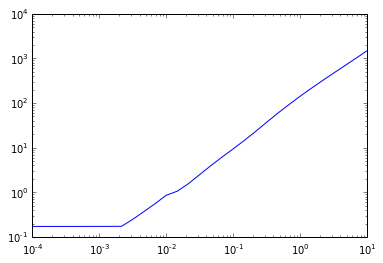

In [318]:
plt.loglog(f_range, Gp)


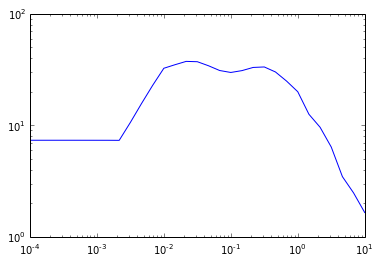

In [319]:
plt.loglog(f_range, Gsec)

In [ ]:
plt.plot(thetime,L_x)

In [ ]:
plt.plot(thetime,sigma_cc)

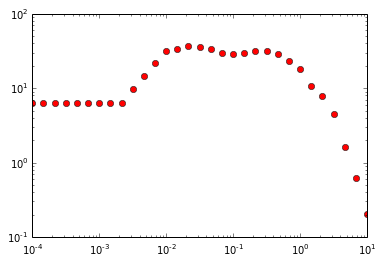

In [316]:
plt.loglog(f_range, abs(Gsec_sin),'ro')

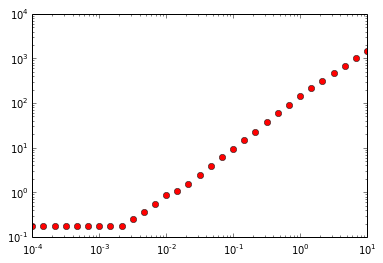

In [317]:
plt.loglog(f_range, abs(Gp_cos),'ro')